# Inception Score Demo


Variational autoencoders, training on MNIST was adapted from:
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/ 
- https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

MNIST Classifier was adapted from CS155 homework 4

## Loading Relevant Libraries

In [2]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## Load MNIST data

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))
print("n_pixels: " + str(n_pixels))

# One-hot encode the MNIST data
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

n_pixels: 784


## Variational Autoencoders

In [5]:
# Set hyperparameters for VAE training.
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)

n_x = X_train.shape[1]
n_y = y_train.shape[1]
n_epoch = 25

### Defining the regular VAE

In [12]:
# Defining the variational autoencoder
X = Input(shape=(n_x,))
encoder_h = Dense(encoder_dim1, activation=activ)(X)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

# Defining the latent space
# reparametrization trick
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

decoder_hidden = Dense(512, activation='relu')
h_p = decoder_hidden(z)

decoder_out = Dense(784, activation='sigmoid')
outputs = decoder_out(h_p)

# Defining the VAE loss
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    # closed from KL divergence between two gaussians
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

# Overall VAE Model
vae = Model([X], outputs)

# Set encoder model
encoder_mu = Model([X], mu)
encoder_sigma = Model([X], l_sigma)

# Set decoder model
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [8]:
# VAE training
vae.compile(optimizer=optim, loss=vae_loss)

vae_hist = vae.fit([X_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                     validation_data = ([X_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 12s 194us/step - loss: 213.1828 - val_loss: 181.4013
Epoch 2/25
60000/60000 [==============================] - 10s 168us/step - loss: 175.1059 - val_loss: 169.9893
Epoch 3/25
60000/60000 [==============================] - 10s 168us/step - loss: 168.0174 - val_loss: 166.6375
Epoch 4/25
60000/60000 [==============================] - 11s 175us/step - loss: 165.4562 - val_loss: 164.7947
Epoch 5/25
60000/60000 [==============================] - 10s 172us/step - loss: 163.7603 - val_loss: 163.3522
Epoch 6/25
60000/60000 [==============================] - 13s 210us/step - loss: 162.4304 - val_loss: 162.2929
Epoch 7/25
60000/60000 [==============================] - 10s 173us/step - loss: 161.2916 - val_loss: 161.1462
Epoch 8/25
60000/60000 [==============================] - 11s 179us/step - loss: 160.1962 - val_loss: 160.0161
Epoch 9/25
600

### Defining the Conditional VAE

In [13]:
# In the CVAE training, we add the one-hot encoded label of the training image to the input to the network. Everything else is exactly the same.
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))
# Concatenate
inputs = concat([X, label])

encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

# reparametrization trick
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

# Setup the model and compile

cvae = Model([X, label], outputs)
cvae_encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
cvae_decoder = Model(d_in, d_out)

In [14]:
cvae.compile(optimizer=optim, loss=vae_loss)

cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 12s 208us/step - loss: 161.6569 - val_loss: 143.3300
Epoch 2/25
60000/60000 [==============================] - 12s 193us/step - loss: 141.4649 - val_loss: 139.8000
Epoch 3/25
60000/60000 [==============================] - 10s 169us/step - loss: 138.9290 - val_loss: 137.9071
Epoch 4/25
60000/60000 [==============================] - 11s 179us/step - loss: 137.4793 - val_loss: 136.8887
Epoch 5/25
60000/60000 [==============================] - 12s 201us/step - loss: 136.4311 - val_loss: 136.0308
Epoch 6/25
60000/60000 [==============================] - 12s 194us/step - loss: 135.6917 - val_loss: 135.4825
Epoch 7/25
60000/60000 [==============================] - 15s 243us/step - loss: 135.1002 - val_loss: 135.0131
Epoch 8/25
60000/60000 [==============================] - 13s 218us/step - loss: 134.6206 - val_loss: 134.6201
Epoch 9/25
60000/60000 [==============================] - 14s 

### Defining the MNIST Classifier

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras import regularizers

model = Sequential()
model.add(Conv2D(40, (3, 3), padding='same',input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2) ))

model.add(Conv2D(160, kernel_size=3, padding="same", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=3, padding="valid", activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(units=90, activation='relu'  ))
model.add(Dropout(0.1))

model.add(Dense(units=90, activation='relu'  ))
model.add(Dropout(0.1))

model.add(Dense(units=90, activation='relu'  ))
model.add(Dropout(0.3))


model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# For a multi-class classification problem
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Refine the input data
(CNN_x_train, CNN_Y_train), (CNN_x_test, CNN_Y_test) = mnist.load_data()

# don't forget to NORMALIZE
CNN_x_train = np.divide(CNN_x_train, 255)
CNN_x_test = np.divide(CNN_x_test, 255)

# we must reshape the X data (add a channel dimension)
CNN_x_train = CNN_x_train.reshape(tuple(list(CNN_x_train.shape) + [1]))
CNN_x_test = CNN_x_test.reshape(tuple(list(CNN_x_test.shape) + [1]))

# Train the model, iterating on the data in batches of 32 samples
history = model.fit(CNN_x_train, y_train, epochs=10, batch_size=32,
                    validation_data=(CNN_x_test, y_test))

eval_train = model.evaluate(x=CNN_x_train, y=y_train)

eval_test = model.evaluate(x=CNN_x_test, y=y_test)
print("train error")
print(eval_train)
print("test error")
print(eval_test)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 301s 5ms/step - loss: 0.2245 - acc: 0.9304 - val_loss: 0.0552 - val_acc: 0.9821
Epoch 2/10
60000/60000 [==============================] - 286s 5ms/step - loss: 0.0705 - acc: 0.9816 - val_loss: 0.0461 - val_acc: 0.9879
Epoch 3/10
60000/60000 [==============================] - 332s 6ms/step - loss: 0.0536 - acc: 0.9857 - val_loss: 0.0307 - val_acc: 0.9917
Epoch 4/10
60000/60000 [==============================] - 314s 5ms/step - loss: 0.0455 - acc: 0.9886 - val_loss: 0.0294 - val_acc: 0.9924
Epoch 5/10
60000/60000 [==============================] - 323s 5ms/step - loss: 0.0362 - acc: 0.9910 - val_loss: 0.0420 - val_acc: 0.9894
Epoch 6/10
60000/60000 [==============================] - 322s 5ms/step - loss: 0.0349 - acc: 0.9916 - val_loss: 0.0380 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 319s 5ms/step - loss: 0.0303 - acc: 0.9923 - val_loss: 0.0402 - 

In [ ]:
print(y_test.shape, X_test.shape)
print(y_train.shape, X_train.shape)

print(y_test.shape, CNN_x_test.shape)
print(y_train.shape, CNN_x_train.shape)

CNN_X_train = X_train.reshape(28,28)
CNN_X_test = X_test.reshape(28,28)

plt.imshow(CNN_X_train[0])

## Drawing samples from the models

In [ ]:
# Draw samples from VAE
def getSamplesVAE(decoder, N_samples):
    latents = np.random.normal(size=(N_samples,2))
    x_decoded = decoder.predict(np.array(latents).reshape(1, 2))
    return x_decoded

# Draw samples from CVAE
def construct_numvec(digit, z = [-1, -1]):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = .5
    out[:, digit + n_z -1] = .5
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

def getSampleCVAE(decoder, N_samples, digit):
    data = []
    for i in range(0,len(N_samples)):
        data.append(decoder.predict(construct_numvec(digit)))
    return np.array(data)

# Reshape input data for MNIST Classifier
def reshapeMNIST(X):
    data = []
    for i in X:
        data.append(i.reshape(28,28))
    data = np.array(data)
    data = data.reshape(tuple(list(data.shape) + [1]))
    return data

def getKLDiv(classifier, X_real, X_gen):
    real_prob = classifier.predict(X_real)
    gen_prob = classifier.predict(X_gen)
    
    # Sum up the distributions
    P = np.sum(real_prob)/len(real_prob)
    Q = np.sum(gen_prob)/len(gen_prob)

    # clip to 1 max so the log probability is not weird
    P = K.clip(P, K.epsilon(), 1)
    Q = K.clip(Q, K.epsilon(), 1)
    return K.sum(P * K.log(P / Q), axis=-1)

### What does computed probabilities look like?

In [68]:
# Generate numbers for VAE



# Generate numbers of CVAE



# List of real numbers


# Inception score for VAE


# Inception score for CVAE


# VAE FID


# CVAE FID


### Plot the latent space of VAE

In [ ]:
def plot_latents(z, Y_train):
    color = ['red','orange','yellow','green','cyan','blue','violet','brown','black','gray']
    np.unique(Y_train)
    # Colorize the latent space by number
    for i in np.unique(Y_train):
        out = z[Y_train==i]
        plt.scatter(out[:,0], out[:,1], color = color[i], s=1, alpha=0.5, label = str(i))        
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.legend()

z_mu = encoder_mu.predict(X_train)
z_sigma = encoder_sigma.predict(X_train)

plt.figure(1,figsize(5,5))
plot_latents(z_mu, Y_train)
plt.title('latent mu')

plt.figure(2,figsize(5,5))
plot_latents(-z_sigma, Y_train)
plt.title('latent sigma')

In [ ]:
plt.imshow(X_train[909].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

We can feed this image into the encoder to see what latent variable settings it has.

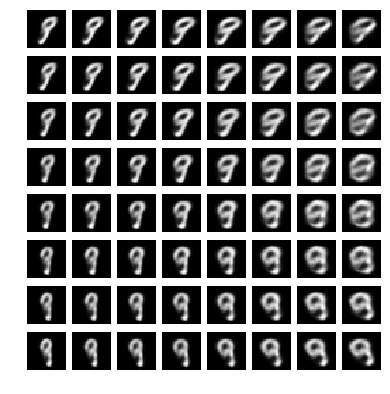

In [107]:
dig = [0,1,2,3,4,5,6,7,8,9]
sides = len(dig)
max_z = 1.5

def getNumbersCVAE(dig, sides, max_z):
    img_it = 0
    for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z)*2) - max_z
        for j in range(0, sides):
            z2 = (((j / (sides-1)) * max_z)*2) - max_z
            z_ = [z1, z2]
            vec = construct_numvec(dig, z_)
            decoded = cvae_decoder.predict(vec)
            subplot(sides, sides, 1 + img_it)
            img_it +=1
            plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

def plotNumbers(numbers):
    img_it = 0
    for i in range(0, sides):
        z1 = (((i / (sides-1)) * max_z)*2) - max_z
        for j in range(0, sides):
            z2 = (((j / (sides-1)) * max_z)*2) - max_z
            z_ = [z1, z2]
            vec = construct_numvec(dig, z_)
            decoded = cvae_decoder.predict(vec)
            subplot(sides, sides, 1 + img_it)
            img_it +=1
            plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()